In [2]:
from mxnet import gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt
from mxnet import autograd as autograd
from mxnet import nd
import mxnet as mx
from collections import namedtuple
import random

In [3]:
def transform(data,label):
    return data.astype('float32')/255,label.astype('float32')

In [4]:
def GetDate():
    fashion_train = gluon.data.vision.FashionMNIST(root='./',train=True,transform=transform)
    fashion_test = gluon.data.vision.FashionMNIST(root='./',train=True, transform=transform)
    return fashion_train,fashion_test

In [5]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net):
    acc = 0.
    test_loss = 0.
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    for data, label in data_iterator:
        data = data.as_in_context(mx.gpu())
        label = label.as_in_context(mx.gpu())
        output = net(nd.transpose(data,(0,3,1,2)))
        loss = softmax_cross_entropy(output, label)
        acc += accuracy(output, label)
        test_loss +=nd.mean(loss).asscalar()
    return acc / len(data_iterator),test_loss / len(data_iterator)

In [6]:
def GetNN():
    net = nn.HybridSequential()
    with net.name_scope():
        net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Conv2D(channels=50, kernel_size=3, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(10))        
    net.initialize(init=mx.init.Xavier(),ctx=mx.gpu())
    net.hybridize()
    return net

In [7]:
def NN_Train(net, train_data, test_data, epochs, batch_size, learning_rate, weight_decay):
    msg=''
    train_loss = []
    train_acc = []
    dataset_train = gluon.data.DataLoader(train_data,batch_size,shuffle=True)
    test_loss = []
    test_acc = []
    dataset_test = gluon.data.DataLoader(test_data,batch_size,shuffle=True)
        
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
    for epoch in range(epochs):
        _loss = 0.
        _acc = 0.
        t_acc = 0.
        for data, label in dataset_train:
            data = nd.transpose(data,(0,3,1,2))
            data = data.as_in_context(mx.gpu())
            label = label.as_in_context(mx.gpu())
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)

            _loss += nd.mean(loss).asscalar()
            _acc += accuracy(output, label)
        __acc = _acc / len(dataset_train) 
        __loss = _loss / len(dataset_train)
        train_loss.append(__loss)
        train_acc.append(__acc)
        
        t_acc,t_loss = evaluate_accuracy(dataset_test, net)
        test_loss.append(t_loss)
        test_acc.append(t_acc)
            
        msg += ("Epoch %d. Train Loss: %f, Test Loss: %f, Train acc %f, Test acc %f\n" % (
            epoch, __loss, t_loss,__acc, t_acc))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(train_loss,'r')
    ax1.plot(test_loss,'g')
    ax1.legend(['Train_Loss','Test_Loss'],loc=2)
    ax1.set_ylabel('Loss')

    ax2 = ax1.twinx()
    ax2.plot(train_acc,'b')
    ax2.plot(test_acc,'y')
    ax2.legend(['Train_Acc','Test_Acc'],loc=1)
    ax2.set_ylabel('Acc')
    
    plt.savefig('1.png',dpi=600)
    plt.show()
    net.collect_params().save('NN.params')
    return msg

In [10]:
epochs = 10
learning_rate = 0.002
batch_size = 128
weight_decay = 0.

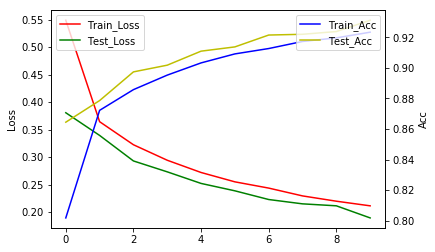

Epoch 0. Train Loss: 0.548921, Test Loss: 0.380608, Train acc 0.801806, Test acc 0.864456
Epoch 1. Train Loss: 0.364341, Test Loss: 0.339355, Train acc 0.872207, Test acc 0.878615
Epoch 2. Train Loss: 0.322395, Test Loss: 0.292920, Train acc 0.885761, Test acc 0.897383
Epoch 3. Train Loss: 0.294191, Test Loss: 0.273078, Train acc 0.895267, Test acc 0.901775
Epoch 4. Train Loss: 0.271903, Test Loss: 0.252009, Train acc 0.903263, Test acc 0.910947
Epoch 5. Train Loss: 0.254892, Test Loss: 0.238550, Train acc 0.909148, Test acc 0.913735
Epoch 6. Train Loss: 0.243520, Test Loss: 0.222731, Train acc 0.912663, Test acc 0.921497
Epoch 7. Train Loss: 0.229306, Test Loss: 0.214853, Train acc 0.917289, Test acc 0.921992
Epoch 8. Train Loss: 0.219663, Test Loss: 0.211280, Train acc 0.919643, Test acc 0.923780
Epoch 9. Train Loss: 0.211239, Test Loss: 0.189257, Train acc 0.923363, Test acc 0.931181



In [11]:
msg = NN_Train(
    net=GetNN(),
    train_data=fashion_train,
    test_data=fashion_test,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay)
print(msg)